In [20]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from astropy.io import fits
from IPython.display import YouTubeVideo
from tools.resample_flux import trapz_rebin
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## <span style="color:#3E2D80">Creating an artificial brain to find the most temperamental of astronomical beasts</span>

If you think New York is a busy place, think again!  Space is full of things continually going bump in the night.  Over its five year survey, DESI will by chance catch potentially thousands of the most tempermental astronomical beasts in the Universe, from [exploding stars](https://en.wikipedia.org/wiki/Supernova) to [merging neutron stars & black holes](https://en.wikipedia.org/wiki/Kilonova) and [stars ripped apart by black holes](https://en.wikipedia.org/wiki/Tidal_disruption_event), not to mention a long list of other fantastic events. 

TODO:  Plot showing stuff happening in the Universe, e.g. size vs rate.  

DESI scientists are smart, but even they can't identify all of these amongst > 30 million spectra!  Fortunately, we have experts that know how to create artificial brains, or neural networks, built to specialize in tasks just like this.  In this notebook, [Segev Ben Zvi](https://www.pas.rochester.edu/~sybenzvi/),

<img src="images/Segev.jpg" alt="Drawing" style="width: 400px;"/>

 will get you up to seed with bleeding edge machine learning and how its used in this hunt.  (Type Ia) supernovae are the most critical to cosmology and we'll first focus on how to identify them (by eye), then we'll teach bits of silicon to do it!

### Core-collapse supernovae

In almost all cases, supernovae are the final stage of the life cycle of the most massive stars (>10$M_{\odot}$, 10 times greater than the mass of the Sun).  Eventually the available fuel sustaining nuclear fusion in the core runs out and the energy used to support the outermost envelope disappears!  Inevitably then, the star collapses under its own weight in a violent explosion lasting just a fraction of a second.  A neutron star will be left behind or, if the progenitor star is massive enough, even a [black hole](https://en.wikipedia.org/wiki/Black_hole).

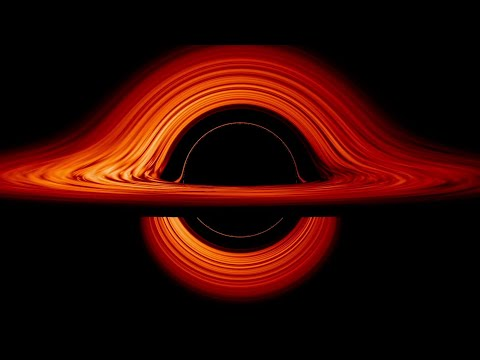

In [3]:
YouTubeVideo('o-Psuz7u5OI', width=800, height=400)

### Binary supernovae

Not all supernovae occur due to core collapse.  In binary systems with a compact White Dwarf and an aged (main sequence) star, the White Dwarf can gravitationally attract material from the envelope of its companion.  If enough material accumulates on the WD surface so that its total mass exceeds the [Chandrasekhar limit](https://en.wikipedia.org/wiki/Chandrasekhar_limit), 1.44$M_\odot$, then a runaway nuclear reaction occurs that blows up the White Dwarf in an intensely bright explosion. These so called type-Ia supernovae are the reason we discovered Dark Energy in the first place!

<img src="images/type1a.jpg" alt="Drawing" style="width: 400px;"/>

These different supernova types are distinguishable by their changing brightness with time - their _`light curve'_ - but if we have the spectrum of the supernova we're much less likely to make a mistake.  Each supernova spectrum has very broad lines distinct in both emission and absorption (Si II, H$\alpha$, Ca II, etc.), from hot gas escaping from the central explosion at high velocity.  These `fingerprints' allow the various types to be distinguished.

<img src="images/sne_filippenko.png" width="600px"/>

Can you tell what's different between these four examples?  Do they have lines in common, and differences?  Over many decades, astronomers have followed this logic and broken it down into a classificaiton of supernovae, which tells us the mechanism behind their origin. 

<img src="images/SupernovaeClassification.png" width="600px"/>

For instance, a type Ib supernovae shows no Hydrogen (H) lines, but exhibits those of Helium.

##  DESI Bright Galaxy Survey

To be bright enough to be detected, the supernovae must live in a relatively nearby galaxy, such as Messier 101,

<img src="images/type1aBGS.jpg" alt="Drawing" style="width: 400px;"/>

With its survey of ten million galaxies in the _local_ Universe, the DESI Bright Galaxy Survey will be perfect for finding these as the light collected by any given fiber will be the total of the galaxy and light from a potential supernovae,    

<img src="images/Messier101.png" alt="Drawing" style="width: 400px;"/>

where we see the same Messier 101 galaxy in the DESI legacy imaging and the area over which light is collected by any given fiber (circles).  We won't know in advance whether there's a supernovae there, of course, so this only works as DESI will observe _a lot_ of galaxies and the rate of supernovae in the Universe is relatively high so we've got good odds!

Let's see what this looks like in practice. 

###  What DESI will see

In [10]:
# Open the data file and show its basic contents.
hdus = fits.open('dat/bgs-supernovae.fits')
hdus.info()

Filename: dat/bgs-supernovae.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  WAVE          1 PrimaryHDU       8   (6265,)   float64   
  1  FLUX          1 ImageHDU         8   (6265, 6)   float64   
  2  IVAR          1 ImageHDU         8   (6265, 6)   float64   
  3  MASK          1 ImageHDU        10   (6265, 6)   int32 (rescales to uint32)   
  4  SPECTYPE      1 BinTableHDU     11   6R x 1C   [10A]   


Here _WAVE_ is simply an array of the observed wavelengths, 

In [18]:
hdus['WAVE'].data

array([3569.60009766, 3570.60009766, 3571.60009766, ..., 9831.59960938,
       9832.59960938, 9833.59960938])

_FLUX_ is the observed intensity of light and _IVAR_ is $(1 \ / \ \rm{expected \ variance})$ of the flux, i.e. from this we can derive the error on this observed flux.  Can you think how?  Given the shape, 

In [19]:
hdus['FLUX'].data.shape

(6, 6265)

we see that we have the flux measured at the same wavelengths as those just above, for six targets. 

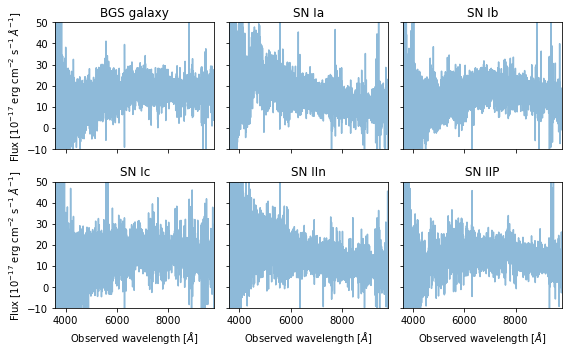

In [22]:
# Plot all the spectra on the same wavelength grid.
fig, axes = plt.subplots(2,3, figsize=(8,5), sharex=True, sharey=True, tight_layout=True)

for i, ax in enumerate(axes.flatten()):
    wave = hdus['WAVE'].data
    flux = hdus['FLUX'].data[i]
    ivar = hdus['IVAR'].data[i]
    spec = hdus['SPECTYPE'].data[i][0]
    
    ax.plot(wave, flux, alpha=0.5)
    ax.set(xlim=(3600, 9800), ylim=(-10,50),
           title=spec)

axes[0,0].set(ylabel=r'Flux [$10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]');
axes[1,0].set(ylabel=r'Flux [$10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]');

for i in range(0,3):
    axes[1,i].set(xlabel=r'Observed wavelength [$\AA$]')

These are fluxes as observed by a given DESI fiber, after we've accounted for the known light from the atmosphere.  In the top left, we have the light emitted by a typical BGS galaxy.  The other panels add a specific type of supernovae to the galaxy light in each case.  The first thing to notice is that this is _a lot_ less clear than what we were expecting from the example spectra above!  

So how can we confirm that the light from the supernovae of each type (Ib, Ic, IIn, IIP) is really there, as claimed?

## Less is more

Our `problem' is that DESI measures the amount of light within very small intervals in wavelength (or color), due to its high resolution.  The spectra of specific targets, in this case supernovae, may not change very much in a small wavelength interval so we end up with many _noisy_ measurements of the same thing - the intensity of light at an average color, or wavelength.  

This is _great_, as we can be smart and simply combine these measurements to get an average value that is much more _precise_. 

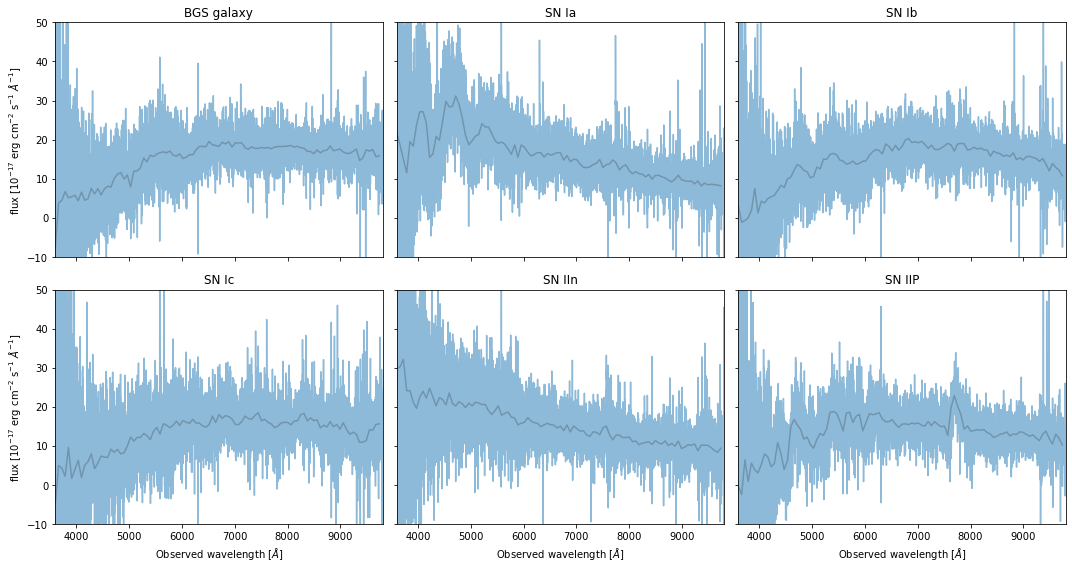

In [40]:
# Plot all the spectra on the same wavelength grid.
fig, axes = plt.subplots(2,3, figsize=(15,8), sharex=True, sharey=True, tight_layout=True)

# Resample the flux on a new wavelength grid with only 100 bins.
coarse_wave = np.linspace(3600, 9800, 101)

for i, ax in enumerate(axes.flatten()):
    wave = hdus['WAVE'].data
    flux = hdus['FLUX'].data[i]
    ivar = hdus['IVAR'].data[i]
    spec = hdus['SPECTYPE'].data[i][0]
    
    ax.plot(wave, flux, alpha=0.5)
        
    fl   = trapz_rebin(wave, flux, edges=coarse_wave)
    
    ax.plot(coarse_wave[:-1], fl, 'k-', alpha=0.2)
    
    ax.set(xlim=(3600, 9800), ylim=(-10,50),
           title=spec)

axes[0,0].set(ylabel=r'flux [$10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]');
axes[1,0].set(ylabel=r'flux [$10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]');

for i in range(0,3):
    axes[1,i].set(xlabel=r'Observed wavelength [$\AA$]')

And now we see much better the characteristic broad dips, or absorption lines, of the supernovae!  Of course, this isn't the only approach.  We could have used statistics and the original 'unbinned' data but things are always better when they're more transparent.  It's still tricky however, as the velocity of the star means that the absorption lines won't be where we would expect them naively.  In this sense, there's _two redshifts_ to the spectrum.   

So we've successfully identified one (simulated, for now!) DESI supernovae, but we could never visually inspect the full survey in this way.  We need a more efficient method ...

## An artificial brain: where anatomy meets astronomy

<img src="images/AIBrain.jpg" alt="Drawing" style="width: 600px;"/>

Given the incredible capacity of the human brain, who wouldn't think to try to understand and replicate it?  Huge progress was made in the 1940s with simple models that led to the bleeding edge _deep learning_ models fundamental to Google, Amazon, and the other tech. giants today.

In biological neurons, dendrites recieve input signals from _thousands_ of neighbouring neurons.  These signals are _combined_ in the nucleus and passed onto an axon.  Only if the combined signal is _greater than a threshold_ value, then the axon will release a prescribed signal. 

<img src="images/Dendrite.jpg" alt="Drawing" style="width: 600px;"/>

This final simple step is where the magic happens.  Prior to this the output signal is a simple weighted sum of the input signals, e.g. $y= a \cdot x + b$.  The possibilites of this setup are relatively limited. 

Thresholding makes the signal _non-linear_, such that when the input signal changes by a _small amount, dx_, the output signal can change by _a lot_.  This, together with the _large number_ of (relatively simple) neurons in the brain allows for almost limitless potential, as represented by the range of possibilities the output, or ideas, that can be formed.  As you read this, there are _100 billion_ neurons potentially firing your imagination.  Who knows what you might come up with!

### Limitless potential

'Deep' machine learning is where these relatively simple ideas meets the raw computing power bestowed upon us by [John von Neumann](https://en.wikipedia.org/wiki/John_von_Neumann), [John Bardeen](https://en.wikipedia.org/wiki/John_Bardeen), ...  Things really took off when the right [hammer](https://en.wikipedia.org/wiki/Graphics_processing_unit) for the problem came to light.

On a computer, but in essentially the same framework, we can have a series of input values, $x_1, x_2, ...$, as would be collected by the dendites, which are weighted and summed, $a_1 \cdot x_1 + a2 \cdot x_2 + ... + b_1 \cdot _ x2 + ...$ as in the axon.  This may happen multiple times, in a series of 'hidden layers', where the output from the previous layer acts as input to the next.  At any stage, although typically the last, 'magic' may be introduced with thresholding, or similar, in a given layer.  Typically, this is referred to as 'activation', in analogy to the firing of an axon.

<img src="images/network.jpg" width="600px"/>

Ahead of time, or _a priori_, we have no idea what the weights of our artificial 'neural network' should be for any given problem.  The capacity of the setup is represented by the number of different outputs that may be generated when any given weight realizes a new number at random, the result of which will typically generate nonsense for a given input.    

But if we can define _success_, as for satisfaction after a good meal or joke, then we can instill _good_ behaviour within the weights.  We repeatable introduce the network to a range of different scenarios and allow the weights, $a_1, ..., b_1, ...$, or entity, to be refined to those that achieve the _greatest success_, as defined by comparison to the 'truth'.  In this way, we can replicate hundreds of generations of [natural selection](https://en.wikipedia.org/wiki/Natural_selection) in a fraction of a second.

### If only life were so simple

The appeal of deep learning is clear, as is its potential downfall:  how many times have you been wrong in your life?  Sure, we're always learning, but science is typically founded on what we know and what we don't, within reason.  You won't survive too long in the field if you predict a different answer than you did six months previously - despite how much you've learnt!  

In other words, the most important thing is to know what you can say _with confidence_.  Typically, neural networks will make a definitive prediction, with no idea on their confidence and potential growth.  As such, we might revisit our ambition ...

### Limited potential

Having admitted our wordly potential, we might sacrifice some of our ability to be perfect, in favour of limiting the _potential to be wrong_.  This may be practical, in that a network with a large number of weights may be foolproof given an infinite computing power, but hugely challenging otherwise.

One of the most effective means to limit the number of weights in our network, and therefore potential to be wrong, is to replace 'fully connected' hidden layers of arbitrary weights with 'convolutional' layers.  A convolution simply replaces a number of neighbouring pixels with a weighted average, as in this case

<img src="images/CMB-lensing.jpg" width="600px"/>

In this way, it is no different from a fully connected layer.  However, it differs that the weights applied within the image are _constant across the image_.  In other words, a 'fully connected' layer allows for a different size, shape and type of glass at any given position of an image.  By restricting ourselves to 'one glass', we greatly reduce the potential of the network, both in its ability to be right and to be wrong.

In this way, we've resorted to arbitrary [matched filters](https://en.wikipedia.org/wiki/Matched_filter) known soon from the invention of radar and sonar.  That's not to say that we don't have some fully connected layers, which might spot anomalies that aren't consistent across a given image.

## The Main Event

First, let's simply open our data archive and list the result.

In [24]:
spectra = np.load('dat/sn_simspectra.npz')
spectra.files

['wave', 'hosts', 'snia', 'snib', 'snic', 'sniip']

and unpack it into something more explicit, 

In [25]:
wave        = spectra['wave']

# Host galaxy.
host_fluxes = spectra['hosts']

snia_fluxes = spectra['snia']
snib_fluxes = spectra['snib']
snic_fluxes = spectra['snic']
snii_fluxes = spectra['sniip']

As previously, this is simply example (host) galaxy spectra, together with examples containing specific classes of supernovae.  To be concrete, let's plot one spectrum from each. 

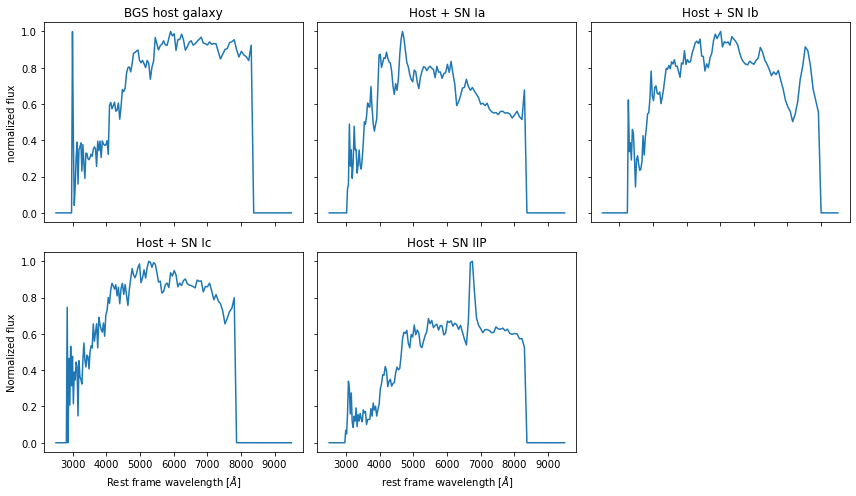

In [28]:
fig, axes = plt.subplots(2,3, figsize = (12,7), tight_layout=True, sharex=True, sharey=True)

ax = axes[0,0]
ax.plot(wave, host_fluxes[0])
ax.set(ylabel='normalized flux',
       title='BGS host galaxy')

ax = axes[0,1]
ax.plot(wave, snia_fluxes[0])
ax.set(title='Host + SN Ia')

ax = axes[0,2]
ax.plot(wave, snib_fluxes[0])
ax.set(title='Host + SN Ib')

ax = axes[1,0]
ax.plot(wave, snic_fluxes[0])
ax.set(xlabel=r'Rest frame wavelength [$\AA$]',
       ylabel='Normalized flux',
       title='Host + SN Ic')

ax = axes[1,1]
ax.plot(wave, snii_fluxes[0])
ax.set(xlabel=r'rest frame wavelength [$\AA$]',
       title='Host + SN IIP')

axes[1,2].axis('off');

There's a lot of possibilities we're asking the network to search between.  To make thinngs easier, these spectra have been 
_preconditioned_.  To achieve this, we've: de-reddened each spectra to remove the affect of the redshift of the observed spectrum;
averaged across neighbouring bins, as previously; renormalized the fluxes to lie between [0, 1] - we're therefore ignoring the brightness 
of the supernovae when determining its type.

## Creating an artificial brain to find the most temperamental of astronomical beasts

We'll first create our artificial brain, and then design challenges that it can attempt repeatedly and _learn_ from.  If we use all our data to create the challenges, then we have no external data to test how well the network is doing - this would be a classic example of [overfitting](https://en.wikipedia.org/wiki/Overfitting).

To avoid this, we'll divide our data into *training* and *validation* sets.  Finally, to be computer friendly, we'll assign simple _integer labels_ to the types we hope the network will be able to guess:  (hosts, Ia, Ib, Ic, IIp) = (0,1,2,3,4) respectively.

In [32]:
# Divide the data into variables x and y, where x=spectra and y=our labels.
nbins = len(wave)

x = np.concatenate([host_fluxes, 
                    snia_fluxes,
                    snib_fluxes,
                    snic_fluxes,
                    snii_fluxes
                   ]).reshape(-1, nbins, 1)

In [33]:
y = to_categorical(
        np.concatenate([np.full(len(host_fluxes), 0), 
                        np.full(len(snia_fluxes), 1),
                        np.full(len(snib_fluxes), 2),
                        np.full(len(snic_fluxes), 3),
                        np.full(len(snii_fluxes), 4)
                       ]))

In [34]:
x.shape, y.shape

((752, 150, 1), (752, 5))

In [35]:
# Training and test splits.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.333)

### The network

We'll initialize a network with a potential limited by three convolutional layers.  You could have less, or more, as determined by the pros and cons above.  We are also going to optimize the network based on its _accuracy_, a metric that maximizes the number of predictions by the network that match the truth.  We could also train on other metrics like _precision_, which minimizes the number of false predictions - this sounds like it should be the same, but it's [not](https://en.wikipedia.org/wiki/Precision_and_recall).

In [36]:
def network(input_shape, ncat, learning_rate=0.0005, reg=0.003, dropout=0.7, seed=None):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories or classes.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [37]:
# Define the network here.
# The input shape will have nbins=150 wavelength bins.
# The number of categories is defined by the shape of our y-vector.
# We should have five categories (hosts, SN Ia, Ib, Ic, and IIP).

cnn_model = network((nbins, 1), ncat=y.shape[1])

In [38]:
cnn_model.summary()

Model: "SNnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Spec (InputLayer)      [(None, 150, 1)]          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 150, 8)            48        
_________________________________________________________________
batch_normalization_3 (Batch (None, 150, 8)            32        
_________________________________________________________________
activation_3 (Activation)    (None, 150, 8)            0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 75, 8)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 75, 16)            656       
_________________________________________________________________
batch_normalization_4 (Batch (None, 75, 16)            64    

Consider this for a minute.  In total, there are 152,405 separate values that can be trained in this network.  That's quite a bit short of the ~10 billion in your own, but its still a lot!  This means that there's considerable potential for the network to get very good a distinguishing spectra will supernovae candidates, but that it will take a lot of learning to get to sensible results.  

### Standing on your own two feet

Now, let the magic happen.  We'll let the network tackle the challenges and design its weights, or neurons, to maximise satisfaction, or its ability to be successful.

In [39]:
history = cnn_model.fit(x_train, y_train, batch_size=50, epochs=125, validation_data=(x_test, y_test), shuffle=True)

Train on 501 samples, validate on 251 samples
Epoch 1/125
501/501 [==============================] - 4s 7ms/sample - loss: 2.9049 - accuracy: 0.2335 - val_loss: 2.7722 - val_accuracy: 0.2550
Epoch 2/125
501/501 [==============================] - 0s 676us/sample - loss: 2.7083 - accuracy: 0.3234 - val_loss: 2.7349 - val_accuracy: 0.2948
Epoch 3/125
501/501 [==============================] - 0s 760us/sample - loss: 2.6175 - accuracy: 0.3533 - val_loss: 2.6968 - val_accuracy: 0.2948
Epoch 4/125
501/501 [==============================] - 0s 722us/sample - loss: 2.5717 - accuracy: 0.3992 - val_loss: 2.6642 - val_accuracy: 0.2430
Epoch 5/125
501/501 [==============================] - 0s 682us/sample - loss: 2.5149 - accuracy: 0.3752 - val_loss: 2.6413 - val_accuracy: 0.1912
Epoch 6/125
501/501 [==============================] - 0s 732us/sample - loss: 2.4131 - accuracy: 0.3912 - val_loss: 2.6251 - val_accuracy: 0.1912
Epoch 7/125
501/501 [==============================] - 0s 678us/sample - l

501/501 [==============================] - 0s 806us/sample - loss: 1.1878 - accuracy: 0.8144 - val_loss: 1.7120 - val_accuracy: 0.5896
Epoch 56/125
501/501 [==============================] - 0s 739us/sample - loss: 1.2197 - accuracy: 0.8024 - val_loss: 1.7051 - val_accuracy: 0.6215
Epoch 57/125
501/501 [==============================] - 0s 743us/sample - loss: 1.2211 - accuracy: 0.7984 - val_loss: 1.8559 - val_accuracy: 0.5657
Epoch 58/125
501/501 [==============================] - 0s 767us/sample - loss: 1.1573 - accuracy: 0.8144 - val_loss: 1.7457 - val_accuracy: 0.5817
Epoch 59/125
501/501 [==============================] - 0s 776us/sample - loss: 1.1582 - accuracy: 0.8144 - val_loss: 1.7515 - val_accuracy: 0.5896
Epoch 60/125
501/501 [==============================] - 0s 767us/sample - loss: 1.1284 - accuracy: 0.8303 - val_loss: 1.6974 - val_accuracy: 0.6135
Epoch 61/125
501/501 [==============================] - 0s 773us/sample - loss: 1.0989 - accuracy: 0.8423 - val_loss: 1.6404 

### Pro, or not pro?

Each time the network attempts the challenge is referred to as an _'epoch'._  As it learns, we should be concerned about the loss: a measure of how badly the network is doing at identifying our spectra, which we want to minimize.  Whereas, the accuracy measures how well the network does at identifying the five different classes simulated, which we want to maximize.

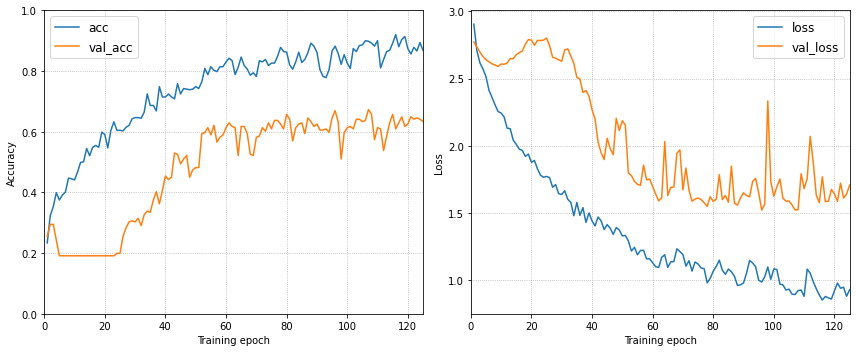

In [42]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)

nepoch = len(history.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, history.history['accuracy'], label='acc')
ax.plot(epochs, history.history['val_accuracy'], label='val_acc')
ax.set(xlabel='Training epoch',
       ylabel='Accuracy',
       xlim=(0, nepoch),
       ylim=(0.,1.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, history.history['loss'], label='loss')
ax.plot(epochs, history.history['val_loss'], label='val_loss')
ax.set(xlabel='Training epoch',
       ylabel='Loss',
       xlim=(0, nepoch),
#        ylim=(0.,2.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

fig.tight_layout();

We can see that the network initially learnt very quickly, but improvement slowed up around 50 epochs or so.  At this point, the accuracy achieved was around 70% - so not bad!

### Confusion Matrix

In this style of classification, another way to measure success is by the _confusion matrix_,

In [43]:
# We're going to use the test sample to test the predictions of our
# trained CNN now that it's "learned" how to tell apart the different
# supernovae. This isn't ideal... we should really have a third data
# sample independent of the training and testing samples.
y_pred = cnn_model.predict(x_test)

# In the multi-class classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

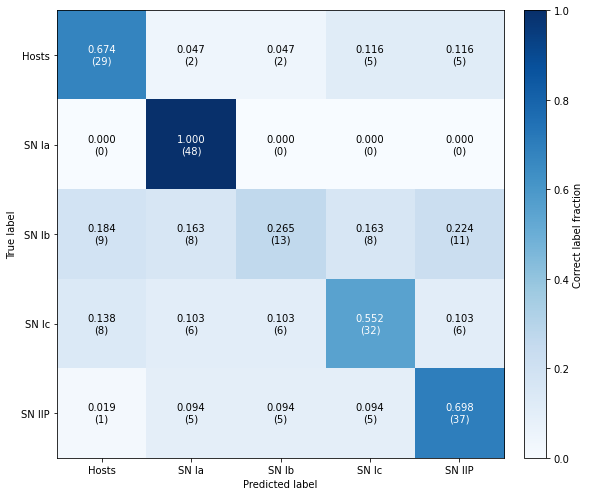

In [46]:
fig, ax = plt.subplots(1,1, figsize=(8,7))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('Correct label fraction')

labels = ['Hosts', 'SN Ia', 'SN Ib', 'SN Ic', 'SN IIP']

ax.set(aspect='equal',
       xlabel='Predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='True label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')

fig.tight_layout()

If the CNN is perfect at classifying every category, then the input 'True label' and the 'Predicted label' output by the network would match every time.  In this case, only the diagonal squares would appear filled in the matrix; The rest would be blank.

In our case, we see the CNN is really good at classifying type-Ia; average at classifying type-IIP; and mediocre at classifying Ib and Ic supernvoae.  It appears to be mixing up type Ib and Ic, and is incorrectly claiming that 30% of host galaxies actually contain a type-Ib supernova.  Oops!

Finally, it's remarkable that we've come full circle, of course, as the silicon foundational to the transitors on which this calculation will be made once originated in the same supernovae we are searching for! 

## Can you do better?

One of the fascinating things about machine learning is that this is an effectively limitless numer of things to tweak that might improve performance.  The art is knowing which things might improve matters for a given problem.

_Increasing the size of the training set_:  We might believe that we've provided insufficient data for the network to learn from.  We have more available in the _validation set_ that we might add, but at what cost?  If the network does improve, is this real, or simply overfitting?  Nevertheless, you might try changing to an '80-20 split'.

_Tailoring the learning and dropout rate_:  How quickly the CNN reacts to new data is determined by a preset _learning rate_ - there's a balance to be stuck to doing better a new problems, while continuing to do well at old ones;  This is often referred to as 'hysteresis' within physics, in analogy to similar effects in magnetism.  You might try changing the learning rate in the $\tt{network}$ call above.


_Changing the 'architecture'_: we've limited the network to three layers, we might add more, or less.  Do you find any significant difference? 

##  So, you like machine learning ...

Well, you're extremely well suited to the likely successes and challenges of the coming century! There is a huge amount of material out there, but the following come highly recommended: [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/), [3blue1brown: Neural Networks](https://youtu.be/aircAruvnKk) and [Deep Learning with Python](https://www.amazon.com/Deep-Learning-Python-Francois-Chollet/dp/1617294438).

It really does have the potential to change everything, as has been stunningly shown [recently](https://www.nature.com/articles/d41586-020-03348-4).